In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# generate sine waves
# random seed
rng = np.random.default_rng(314159265358979)
rng.integers(-3, 2, size=7)

# generate data
L = 32
row_count = 100
col_count = 1000

x = np.empty((row_count, col_count), 'int64')   # todo benchmark
x[:] = np.array(rng.integers(low=-4 * L, high=4 * L, size=row_count).reshape(row_count, 1) + range(col_count))
x = np.sin(x / 1.0 / L).astype('float64')

torch.Size([100, 1000])
211
212


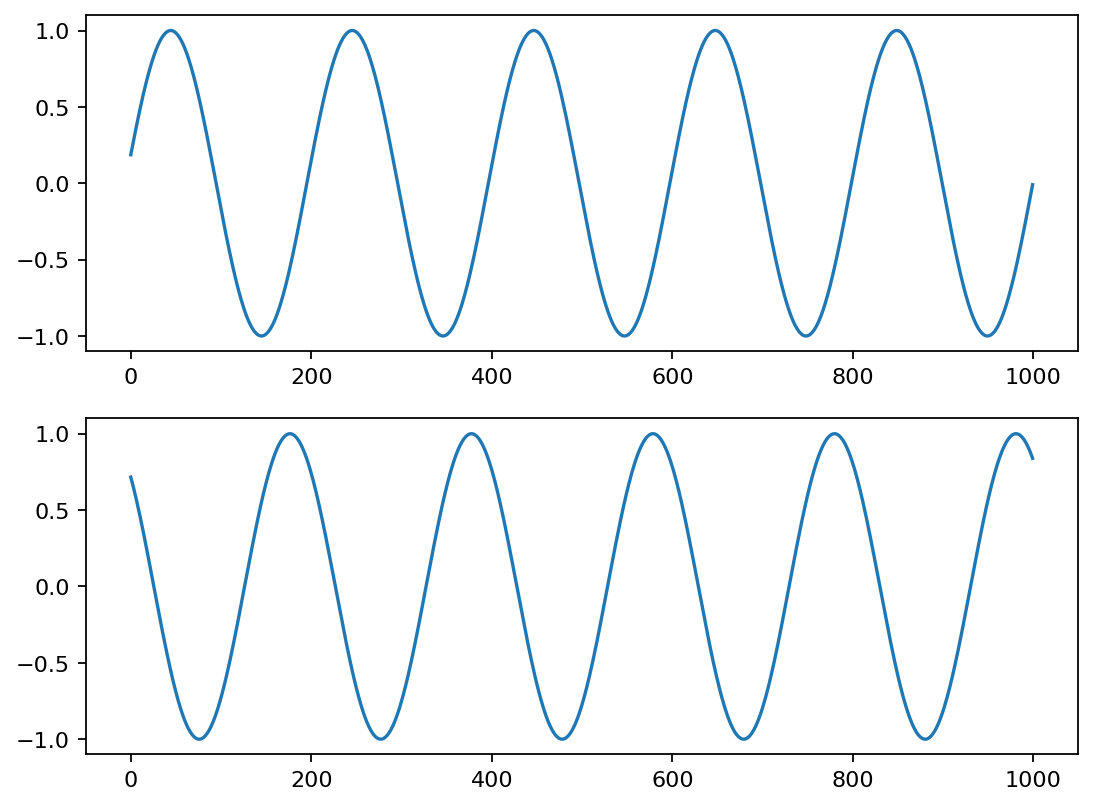

In [3]:
data = torch.from_numpy(x)
print(data.shape)

def plot_1d(*args):
    """plot data"""
    num_of_ax = len(args)
    fig = plt.figure(figsize=(8, 6), dpi=160)

    ax_list = []
    for i in range(num_of_ax):
        print(f"{num_of_ax}1{i+1}")
        ax_list.append(fig.add_subplot(int(f"{num_of_ax}1{i+1}")))
        ax_list[i].plot(args[i])
        # ax_list[i].set(title='Data View', ylabel='Y-Axis', xlabel='X-Axis')
                       
    plt.show()

    return None

plot_1d(x[0], x[99])

In [4]:
class LSTM_Sequence(nn.Module):
    """"""
    def __init__(self, input_size, h_size, output_size):
        super().__init__()
        self.lstm1 = nn.LSTMCell(input_size, h_size)
        self.lstm2 = nn.LSTMCell(h_size, h_size)
        self.linear = nn.Linear(h_size, output_size)

    def forward(self, x_t, future = 0):
        batch_size = x_t.size(0) 
        h1 = torch.zeros(batch_size, h_size, dtype=torch.double)
        c1 = torch.zeros(batch_size, h_size, dtype=torch.double)
        h2 = torch.zeros(batch_size, h_size, dtype=torch.double)
        c2 = torch.zeros(batch_size, h_size, dtype=torch.double)

        output_list = [] 
        for x in torch.split(x_t, 1, dim=1):
            h1, c1 = self.lstm1(x, (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
            output_list.append(output)
        
        for i in range(future):
            h1, c1 = self.lstm1(output, (h2, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
            output_list.append(output)
        
        outputs = torch.cat(output_list, dim=1)
        return outputs


In [5]:
x_train = data[:-3, :-1]
y_train = data[:-3, 1:]
x_test = data[-3:, :-1]
y_test = data[-3:, 1:]

input_size = 1
h_size = 64
output_size = 1

model = LSTM_Sequence(input_size, h_size, output_size)
model.double()  # NOTE, the model weights default to dtype float32

loss_fn = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)

In [6]:
from numpy.lib.utils import deprecate
epochs = 10
def train(epoch_index, tb_writer=None)->float:
    """"""
    running_loss = 0.
    last_loss = 0.

    def closure():
        outputs = model(x_train)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        return loss
        print(f"batch {i + 1} loss: {loss.item():8.4f}")

    l = optimizer.step(closure)
    print(l)
    return model(x_test)


results = []
for epoch in range(epochs):
    print(f"EPOCH {epoch + 1}:")
    results.append(train(epoch).detach().numpy())

EPOCH 1:
tensor(0.5027, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 2:
tensor(0.0025, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 3:
tensor(0.0003, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 4:
tensor(0.0001, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 5:
tensor(8.8245e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 6:
tensor(6.1172e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 7:
tensor(2.2103e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 8:
tensor(1.5941e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 9:
tensor(8.6172e-06, dtype=torch.float64, grad_fn=<MseLossBackward0>)
EPOCH 10:
tensor(4.7827e-06, dtype=torch.float64, grad_fn=<MseLossBackward0>)


911
912
913
914
915
916
917
918
919


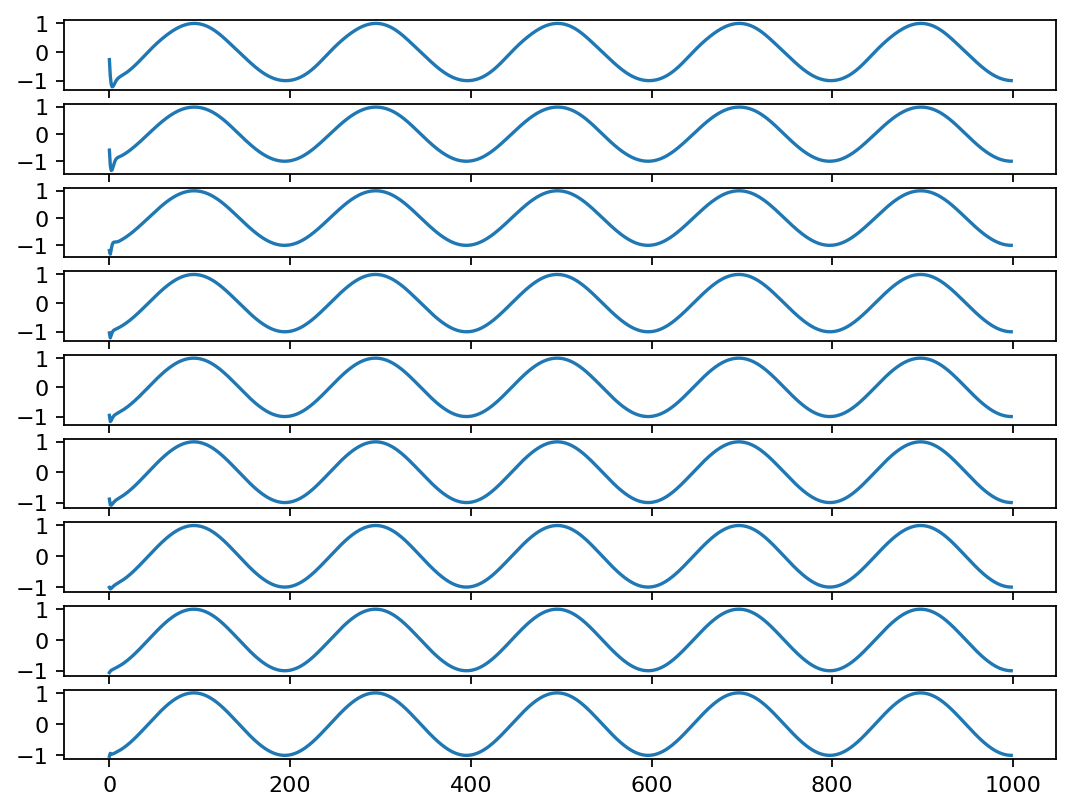

In [7]:
# test
# model.train(False)
# y = model(x_test)
# plot_1d(y[0].detach().numpy(), y_test[0].numpy())
# plot_1d(*results)
results[0].shape
nr = [x[0] for x in results[1:]]
plot_1d(*nr)


In [34]:
l = train(1)

tensor(3.6404e-06, dtype=torch.float64, grad_fn=<MseLossBackward0>)
